In [1]:
!pip install pandas numpy scipy kadlu kaleido==0.2.1 matplotlib pyarrow pooch seaborn plotly xarray ipywidgets cfgrib cartopy

In [2]:
import kadlu
#from kadlu.geospatial.interpolation import Interpolator2D

from datetime import datetime
import matplotlib.pyplot as plt

kadlu.storage_cfg(setdir='./kadlu_data/')

/home/jovyan/work/notebook/kadlu_data/

In [3]:
# load some data to interpolate
bathy, lat, lon = kadlu.load(
        var='bathymetry', source='gebco',
        south=43, west=-63, 
        north=58, east=-59
    )


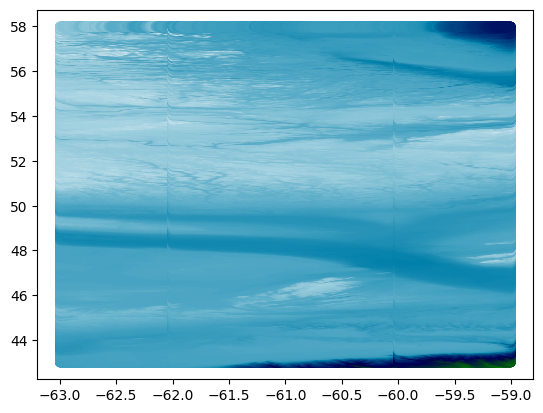

In [4]:
# quick overview of bathymetric data
fig = plt.scatter(lon, lat, c=bathy, cmap=plt.cm.ocean_r)

In [5]:
bathy[-100], lon[-100],lat[-100]

(1375.0, -59.41458333333334, 57.99791666666667)

In [6]:
#kadlu.era5_cfg(key="TOKEN_HERE", url="URL_HERE")

In [7]:
import cdsapi

client = cdsapi.Client()

dataset = 'reanalysis-era5-pressure-levels'
request = {
  'product_type': ['reanalysis'],
  'variable': ['geopotential'],
  'year': ['2024'],
  'month': ['03'],
  'day': ['01'],
  'time': ['13:00'],
  'pressure_level': ['1000'],
  'data_format': 'grib',
}
target = 'download.grib'

client.retrieve(dataset, request, target)

2025-09-22 07:11:05,101 WARNING [2025-09-19T00:00:00] Scheduled System Session affecting Service reliability - 22 September 2025. Please follow status [here](https://status.ecmwf.int/) or in our [forum](https://forum.ecmwf.int/t/scheduled-maintenance-of-the-cloud-infrastructure-on-22-september-2025/14173)
[2025-09-19T00:00:00] Scheduled System Session affecting Service reliability - 22 September 2025. Please follow status [here](https://status.ecmwf.int/) or in our [forum](https://forum.ecmwf.int/t/scheduled-maintenance-of-the-cloud-infrastructure-on-22-september-2025/14173)
2025-09-22 07:11:05,102 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-22 07:11:05,104 INFO [2024-09-26T00:00:00] 

79e8588ed2d6bf970f3f56839d004865.grib:   0%|          | 0.00/1.98M [00:00<?, ?B/s]

'download.grib'

In [8]:
import xarray as xr; 
ds = xr.open_dataset('download.grib', engine='cfgrib')

Ignoring index file 'download.grib.5b7b6.idx' older than GRIB file
/opt/conda/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode the variable 'step' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


In [9]:
print(ds)

<xarray.Dataset> Size: 4MB
Dimensions:        (latitude: 721, longitude: 1440)
Coordinates:
    number         int64 8B ...
    time           datetime64[ns] 8B ...
    step           timedelta64[ns] 8B ...
    isobaricInhPa  float64 8B ...
  * latitude       (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude      (longitude) float64 12kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
    valid_time     datetime64[ns] 8B ...
Data variables:
    z              (latitude, longitude) float32 4MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-09-22T07:11 GRIB to CDM+CF via cfgrib-0.9.1...


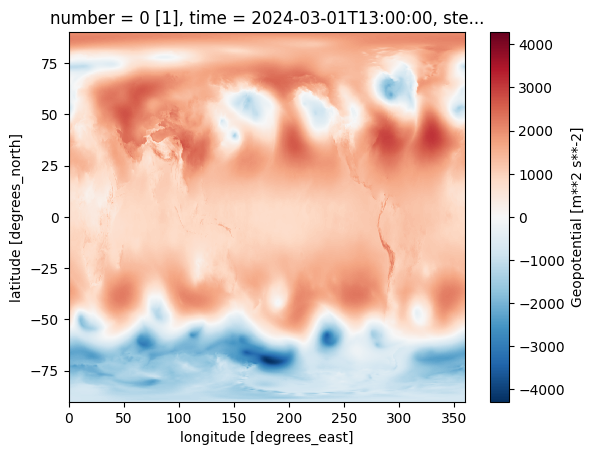

In [10]:
ds['z'].plot()
#KeyError: "No variable named 'geopotential'. Variables on the dataset include ['number', 'time', 'step', 'isobaricInhPa', 'latitude', 'longitude', 'valid_time', 'z']"

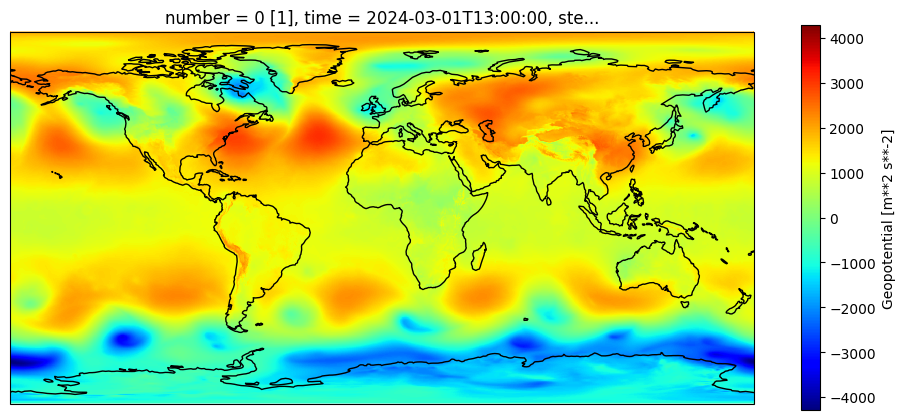

In [11]:
import cartopy.crs as ccrs
fig = plt.figure(figsize=[12,5])

# 111 means 1 row, 1 col and index 1
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))

ds['z'].plot(ax=ax, cmap='jet',
                   transform=ccrs.PlateCarree())
ax.coastlines()

plt.show()

In [12]:
import numpy as np
from datetime import datetime

from kadlu import plot_util
#from kadlu.plot_util import plot2D
from kadlu import source_map, gebco, era5, hycom, wwiii

# enable plots embedded in jupyter notebook:
%matplotlib inline

In [13]:
# figure boundaries to pass as arguments to the plot function
kwargs = dict(
        south=43.8, west=-63, 
        north=47.5, east=-59,
        bottom=0, top=0,
        start=datetime(2018, 12, 12), end=datetime(2018, 12, 13)
)
#kwargs = dict(
#        south=44, west=-63, 
#        north=56, east=-59,
#        bottom=0, top=0,
#        start=datetime(2018, 12, 12), end=datetime(2018, 12, 13)
#)

In [14]:
import os
import logging
from datetime import datetime, timedelta
from multiprocessing import Process, Queue

import numpy as np
import imageio
import matplotlib
#matplotlib.use('TkAgg')
#matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
import cartopy
#import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata

from kadlu.geospatial.data_sources.source_map import load_map
from kadlu.geospatial.data_sources.data_util import fmt_coords
from kadlu.geospatial.data_sources.data_util import storage_cfg

In [15]:
config = dict(
        bgcontour   = lambda v: np.linspace(min(v)-.1, max(v)+.1, 3),
        bathymetry=dict(
            cm      = plt.cm.bone.reversed(),
            alpha   = 0.9,
            #levels  = lambda v, n=24: np.linspace(1, max(v)-1, n),
            levels  = lambda v, n=12: np.linspace(1, max(v)-1, n),
            norm    = lambda v: matplotlib.colors.Normalize(vmin=0, vmax=max(v)-1),
            title   = 'bathymetry (metres)'),
        temp=dict(
            cm      = plt.cm.coolwarm, 
            alpha   = 0.8,
            levels  = lambda v, n=12: np.linspace(min(v)-.1, max(v)+.1, n),
            norm    = lambda v=None: matplotlib.colors.Normalize(vmin=-5, vmax=20),
            title   = 'temperature (celsius)'),
        salinity=dict(
            cm      = plt.cm.viridis,
            alpha   = 0.7,
            levels  = lambda v, n=12: np.linspace(min(v)+.1, max(v), n),
            norm    = lambda v=None: matplotlib.colors.Normalize(vmin=20, vmax=40),
            title   = 'salinity (g/kg salt in water)'),
        waveheight=dict(
            cm      = plt.cm.BuPu,
            alpha   = 0.85,
            levels  = lambda v, n=12: np.linspace(min(v)+.1, max(v), n),
            norm    = lambda v=None: matplotlib.colors.Normalize(vmin=0, vmax=15),
            title   = 'wave height (metres)'),
        wavedirection=dict(
            cm      = plt.cm.BuPu,
            alpha   = 0.85,
            levels  = lambda v, n=12: np.linspace(min(v)+.1, max(v), n),
            norm    = lambda v=None: matplotlib.colors.Normalize(vmin=0, vmax=15),
            title   = 'wave direction (direction)')
    )

def plot2D(var, source, plot_wind=False, save=False, wide=12, tall=8, **kwargs): 
    """
    
        import kadlu
        var = 'bathymetry'
        source = 'gebco'
        plot_wind, save = False, False
        kwargs = kadlu.defaults
        kadlu.plot2D(var, source, **kwargs)

    """
    var = var.lower()
    source = source.lower()

    if f'{var}_{source}' not in load_map.keys():
        raise KeyError(f'could not find source for variable. valid vars and '
                       f'sources: {[k.split("_") for k in load_map.keys()]}')

    if 'start' not in kwargs.keys():
        kwargs['start'], kwargs['end'] = datetime.now(), datetime.now()

    data = np.array(load_map[f'{var}_{source}'](**kwargs))
    #val, lat, lon = data[:3].astype(float)
    val, lat, lon = data[:3].astype(float)
    
    # project data onto coordinate space
    extent = ccrs.Mercator().transform_points(
            ccrs.Geodetic(),
            np.array([kwargs['west'], kwargs['east']]), 
            np.array([kwargs['south'], kwargs['north']])
        )[:,:-1]
    projected_lonlat = ccrs.Mercator().transform_points(
            ccrs.Geodetic(),
            lon,
            lat
        )
    plon = projected_lonlat[:,0]
    plat = projected_lonlat[:,1]
    num_lats = 1000
    num_lons = 1000
    lons = np.linspace(start=min(plon), stop=max(plon), num=num_lons)
    lats = np.linspace(start=min(plat), stop=max(plat), num=num_lats)
    data = griddata(points=(plon, plat), values=val, xi=(lons[None,:],lats[:,None]), method='linear')
    coast = cfeature.NaturalEarthFeature('physical', 'coastline', '10m')
    fg = (.92, .92, .92, 1)
    fname = f'{var}_{kwargs["start"].date().isoformat()}.png'
    fig = plt.figure(figsize=[wide, tall])
    #fig, ax = plt.subplots(figsize=(12, 8))

    ax = fig.add_subplot(1, 1, 1, 
            title=config[var]['title']+f'\n{kwargs["start"].date().isoformat()}',
            projection=ccrs.Mercator(), 
            facecolor=config[var]['cm'](256), 
            frameon=True
        )
    ax.contourf(lons, lats, data,
                transform=ccrs.Mercator(),
                levels=config[var]['levels'](val),
                cmap=config[var]['cm'], 
                alpha=config[var]['alpha'],
                zorder=8
            )
    ax.contour(lons, lats, data,
                transform=ccrs.Mercator(),
                levels=config[var]['levels'](val),
                cmap=config[var]['cm'],
                alpha=1,
                linewidths=2,
                zorder=9
            )

    if plot_wind is not False:
        if plot_wind.lower() == 'era5': 
            #windfcnU, windfcnV = (Era5().load_wind_u, Era5().load_wind_v)
            windfcnU, windfcnV = load_map['wind_u_era5'], load_map['wind_v_era5']
        elif plot_wind.lower() == 'wwiii': 
            #windfcnU, windfcnV = (Wwiii().load_wind_u, Wwiii().load_wind_v)
            windfcnU, windfcnV = load_map['wind_u_wwiii'], load_map['wind_v_wwiii']
        else: 
            raise ValueError('invalid wind source. must be \'era5\' or \'wwiii\'')

        uval, ulat, ulon, utime = windfcnU(**kwargs)
        vval, vlat, vlon, vtime = windfcnV(**kwargs)
        assert(len(vval) == len(uval))  # this can be fixed with an SQL JOIN in load module
        if len(np.unique(ulat)) == 1 or len(np.unique(ulon)) == 1:
            raise RuntimeError(f'Not enough datapoints to plot windspeeds in region {fmt_coords(kwargs)}')

        ax.quiver(ulon, ulat, uval, vval, transform=ccrs.PlateCarree(), 
                regrid_shape=20, zorder=10)

    ax.add_feature(coast, facecolor=fg, edgecolor=(0,0,0,1), zorder=11)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--',
            zorder=12)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER

    # this appears to be a known bug
    # https://github.com/SciTools/cartopy/issues/1332
    for tick in ax.get_xticklabels(): 
        tick.set_rotation(45)

    gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER
    ax.tick_params(axis='x', rotation=45)
    vnorm = val if var == 'bathy' or var == 'bathymetry' else None
    plt.colorbar(matplotlib.cm.ScalarMappable(norm=config[var]['norm'](vnorm),
                cmap=config[var]['cm']), ax=ax)

    if save is not False:
        if not os.path.isdir(f'{storage_cfg()}figures'): 
            os.mkdir(f'{storage_cfg()}figures')
        logging.info(f'saving figure to {storage_cfg()}figures/{fname if save is True else save}')
        
        plt.savefig(f'{storage_cfg()}figures/{fname if save is True else save}', 
                bbox_inches='tight', dpi=200)
                #bbox_inches='tight', dpi=200, figsize=(12,8), optimize=True)
        plt.close()
    else: 
        plt.show()

    return

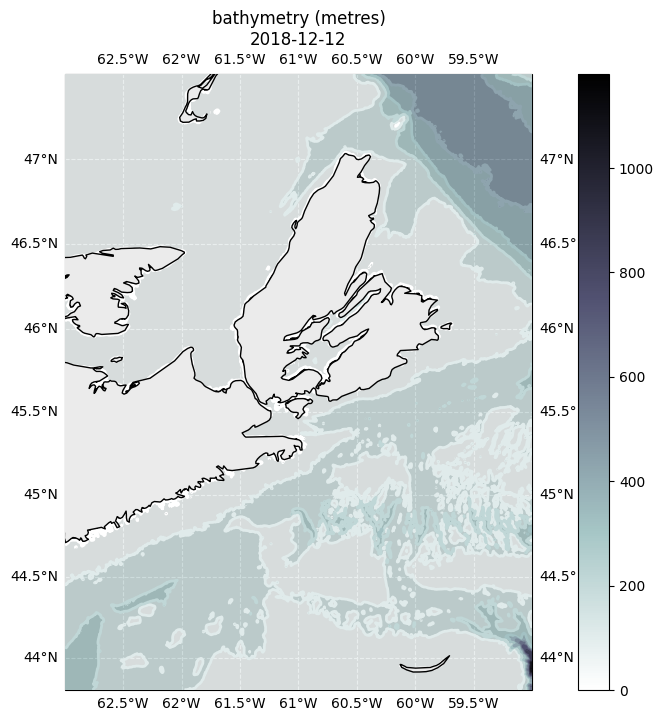

In [16]:
plot2D(var='bathymetry', source='gebco', **kwargs)
#plot2D(var='salinity', source='hycom', **kwargs)
#plot_util.plot2D(var='salinity', source='hycom', **kwargs)
#        south=43, west=-63, 
#        north=58, east=-59

In [17]:
# figure boundaries to pass as arguments to the plot function
kwargs = dict(
        south=43.8, west=-63, 
        north=47.25, east=-59.25,
        bottom=200, top=0,
        start=datetime(2018, 12, 12), end=datetime(2018, 12, 13)
)

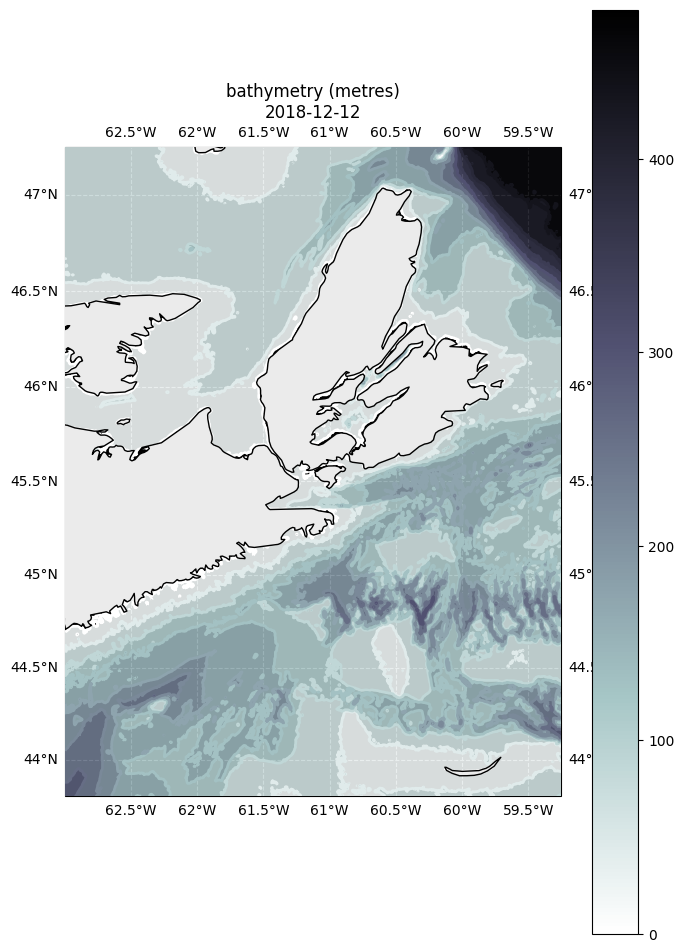

In [18]:
plot2D(var='bathymetry', source='gebco', wide=8, tall=12, **kwargs)

In [19]:
plot2D(var='bathymetry', source='gebco', save=True, wide=8, tall=10, **kwargs)

saving figure to /home/jovyan/work/notebook/kadlu_data/figures/bathymetry_2018-12-12.png


In [20]:
# figure boundaries to pass as arguments to the plot function
#kwargs = dict(
#        south=44, west=-63, 
#        north=48, east=-59
#)

# ocean boundaries
bounds = dict(
               south=43.53, north=44.29, west=-59.84, east=-58.48,
               start=datetime(2022,9,24), end=datetime(2022,9,25), 
               top=0, bottom=10000
             )

In [21]:
# data sources
data_sources = dict(load_bathymetry='gebco', 
                    load_temperature='hycom', 
                    load_salinity='hycom',
                    #load_wind_uv='wwiii', 
                    load_wind_uv='era5',
                    #load_waveheight='wwiii')
                    load_waveheight='era5')
# initialize Ocean instance
gully = kadlu.Ocean(**bounds, **data_sources)

Initializing Ocean in region 43.53°N,44.29°N;59.84°W58.48°W,10000m,0m for time period 2022-09-24 00:00:00 to 2022-09-25 00:00:00 with variables: ['bathymetry', 'temperature', 'salinity', 'wind_uv', 'waveheight']
Finished loading bathymetry
  value: shape=(59841,) min=-10.000 max=3263.000 avg=582.418
    lat: shape=(59841,) min=43.531 max=44.290 avg=43.910
    lon: shape=(59841,) min=-59.840 max=-58.481 avg=-59.160
[HYCOM] Fetching salinity in region 43.53°N,44.29°N;59.84°W58.48°W,10000m,0m for time period 2022-09-24 00:00:00 to 2022-09-25 00:00:00
Finished loading salinity
  value: shape=(64692,) min=30.966 max=35.228 avg=32.752
    lat: shape=(64692,) min=43.560 max=44.280 avg=43.880
    lon: shape=(64692,) min=-59.760 max=-58.560 avg=-59.099
  epoch: shape=(64692,) min=199248.000 max=199272.000 avg=199260.000
  depth: shape=(64692,) min=0.000 max=2500.000 avg=129.995
The data points only cover 45.8% of the full rectangular box
Interpolating 273600 data points on 4D irregular grid usi

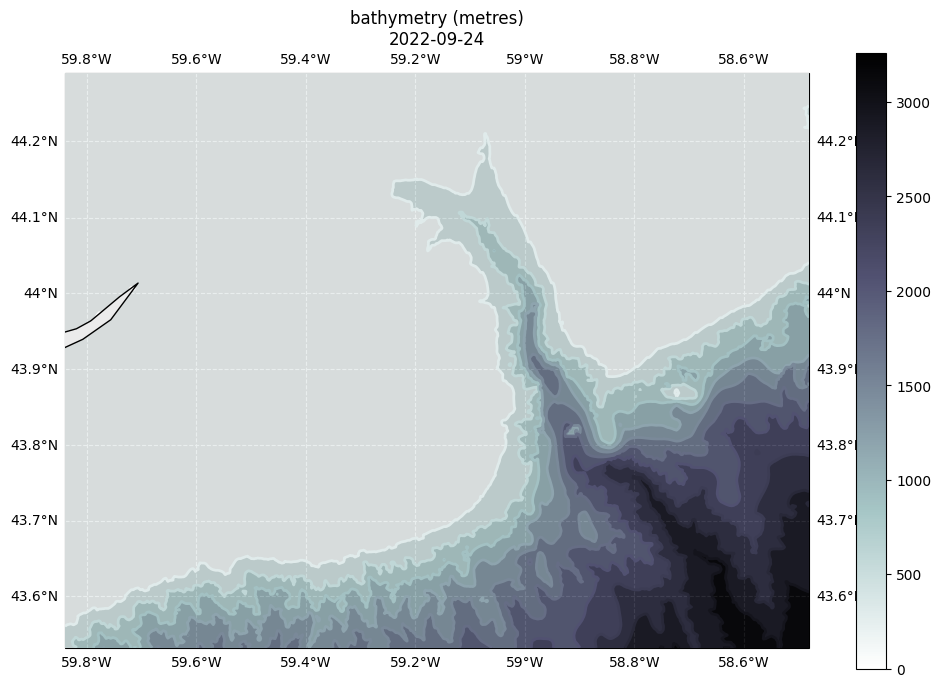

In [22]:
#plot2D(var='bathymetry', source='gebco', **kwargs)

#plot2D(var='bathymetry', source='gebco', **bounds)

plot2D(var='bathymetry', source='gebco', **bounds)

In [23]:
# data sources
#data_sources = dict(load_bathymetry='gebco',  
#                    load_wind_uv='era5',
#                    load_waveheight='era5',
#                    load_wavedirection='era5')
# initialize Ocean instance
#gullywind = kadlu.Ocean(**bounds, **data_sources)

In [24]:
#plot2D(var='waveheight', source='era5', plot_wind='era5', **bounds)
# specify bottom acoustic properties
seafloor = {'sound_speed':1700,'density':1.5,'attenuation':0.5}

In [25]:
#sound_source = {'freq': 200, 'lat': 43.9, 'lon': -59.2, 'source_depth': 12}
sound_source = {'freq': 200, 'lat': 43.9, 'lon': -58.99, 'source_depth': 50}

In [26]:
from kadlu.sound.geophony import transmission_loss

In [27]:
# initialize transmission loss object
transm_loss = transmission_loss(seafloor=seafloor, 
                                propagation_range=60, 
                                **sound_source,
                                **bounds, 
                                **data_sources)

# calculate transmission loss (be patient, this may take a while ...)
_ = transm_loss.calc(rec_depth=[0.1, 30], vertical=True, nz_max=1000)

Initializing Ocean in region 43.25°N,44.55°N;59.89°W58.09°W,10000m,0m for time period 2022-09-24 00:00:00 to 2022-09-25 00:00:00 with variables: ['bathymetry', 'temperature', 'salinity', 'wind_uv', 'waveheight']
Finished loading bathymetry
  value: shape=(133610,) min=-10.000 max=3839.000 avg=1049.920
    lat: shape=(133610,) min=43.256 max=44.544 avg=43.900
    lon: shape=(133610,) min=-59.885 max=-58.094 avg=-58.990
[HYCOM] Fetching salinity in region 43.25°N,44.55°N;59.89°W58.09°W,10000m,0m for time period 2022-09-24 00:00:00 to 2022-09-25 00:00:00
Finished loading salinity
  value: shape=(166374,) min=30.952 max=35.320 avg=33.060
    lat: shape=(166374,) min=43.280 max=44.520 avg=43.802
    lon: shape=(166374,) min=-59.840 max=-58.160 avg=-58.940
  epoch: shape=(166374,) min=199248.000 max=199272.000 avg=199260.000
  depth: shape=(166374,) min=0.000 max=3000.000 avg=210.343
Interpolating 633600 data points on 4D irregular grid using method `nearest` and batch size of 10000
100%|███

<Figure size 800x1000 with 0 Axes>

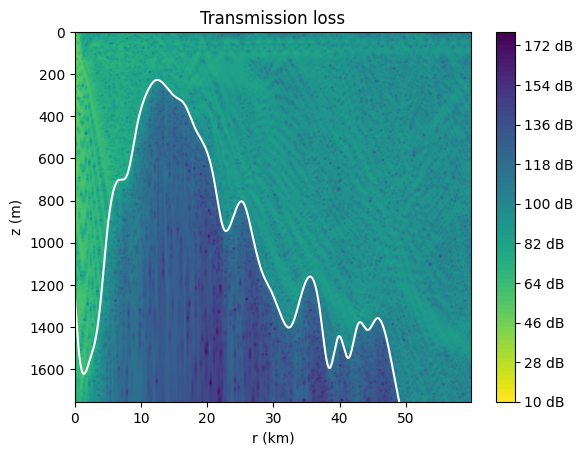

In [28]:
#transmission loss with bathy and ssp superimposed
fig2 = plt.figure(figsize=[8, 10])
fig2 = transm_loss.plot_vert(angle=0, max_depth=1770) #, show_ssp=True)
plt.savefig(f'{storage_cfg()}figures/plot_vert_hurricane01.png', 
                bbox_inches='tight', dpi=200)

In [29]:
#plt.savefig(f'{storage_cfg()}figures/plot_vert_hurricane01.png', 
#                bbox_inches='tight', dpi=200)

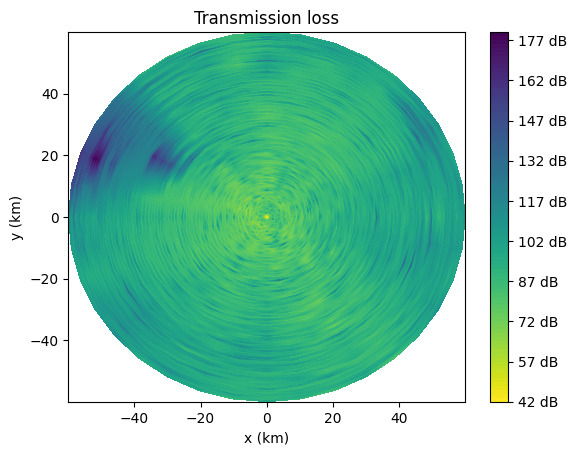

In [30]:
#fig = plt.figure(figsize=[8, 10])
fig = transm_loss.plot_horiz(rec_depth_idx=1)  # transmission loss at 30 m depth (receiver no. 2)
#plt.savefig(f'{storage_cfg()}figures/plot_horizon_hurricane01.png', 
#                bbox_inches='tight', dpi=200)

Initializing Ocean in region 44.25°N,44.70°N;64.50°W63.33°W,5000m,0m for time period 2015-03-01 00:00:00 to 2015-03-01 12:00:00 with variables: ['bathymetry']
Finished loading bathymetry
  value: shape=scalar min=2000.000 max=2000.000 avg=2000.000
100%|██████████| 2000/2000 [00:28<00:00, 71.22it/s]


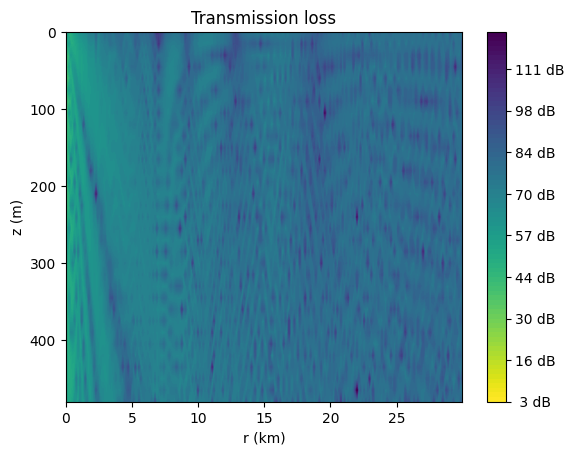

In [31]:
transm_loss = transmission_loss(freq=100, source_depth=75, propagation_range=30, 
                                load_bathymetry=2000, ssp=1480)

# calculate transmission loss
_ = transm_loss.calc(vertical=True)

# plot
fig = transm_loss.plot_vert(angle=0, max_depth=500)

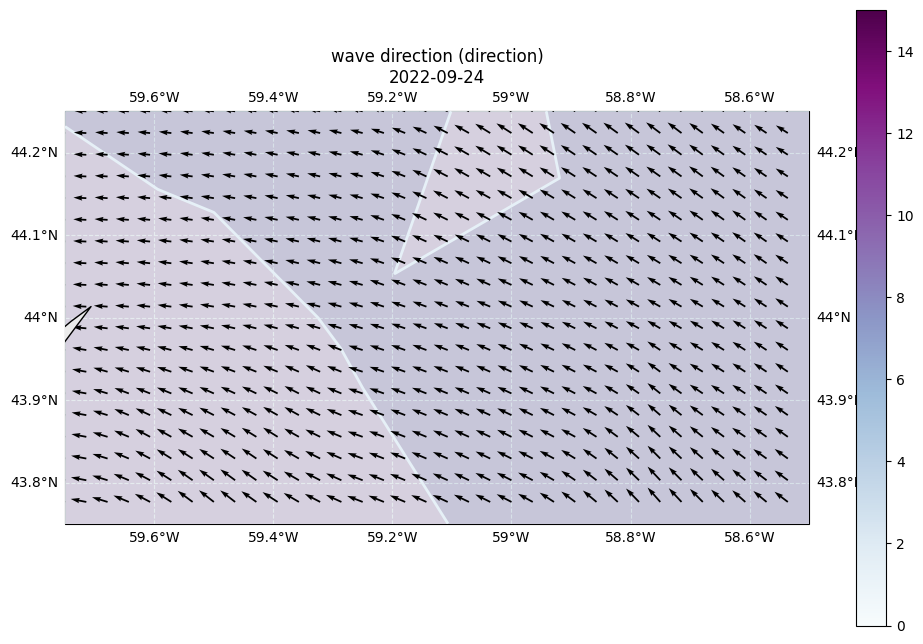

In [32]:
plot2D(var='wavedirection', source='era5', plot_wind='era5', **bounds)

In [33]:
#x = np.linspace(-58.48, -59.84, 100)
#y = np.linspace(43.53, 44.29, 100)
#ws = gullywind.wind_uv(lon=x,lat=y,epoch=1,grid=True)
#wh = gullywind.waveheight(lon=x,lat=y,epoch=1,grid=True)
#x, y = np.meshgrid(x, y)
# plot windspeed
#plt.contourf(x,y,ws)

#plt.xlabel('Longitude (deg)')
#plt.xlabel('Latitude (deg)')
#plt.colorbar(format='%2.0f m/s')
#plt.show()
# plot waveheight
#plt.contourf(x,y,wh)
#plt.xlabel('Longitude (deg)')
#plt.xlabel('Latitude (deg)')
#plt.colorbar(format='%2.0f m')
#plt.show()

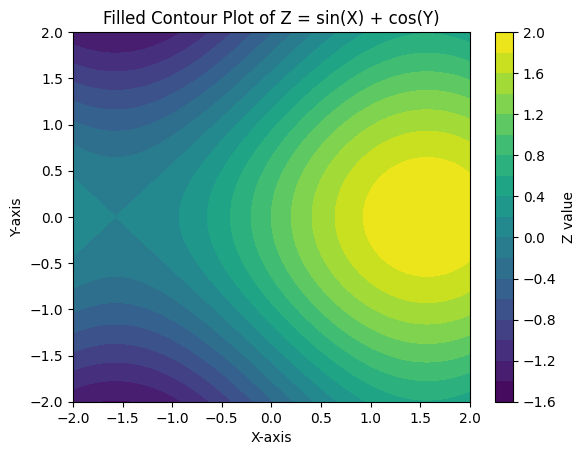

In [34]:
# Create 1D arrays for x and y
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)

# Create 2D meshgrids for X and Y
X, Y = np.meshgrid(x, y)

# Define a 2D function for Z
Z = np.sin(X) + np.cos(Y)

# Create the filled contour plot
plt.contourf(X, Y, Z, levels=20, cmap='viridis') # 20 levels, 'viridis' colormap
plt.colorbar(label='Z value') # Add a color bar
plt.title('Filled Contour Plot of Z = sin(X) + cos(Y)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [68]:
# ocean boundaries
#bounds2 = dict(
#               south=43.53, north=44.29, west=-59.84, east=-58.48,
#               start=datetime(2022,8,24), end=datetime(2022,8,25), 
#               top=0, bottom=10000
#             )
bounds3 = dict(
               south=44, north=45, west=-61, east=-60,
               start=datetime(2022,8,24), end=datetime(2022,8,25), 
               top=0, bottom=1000
             )

In [69]:
# data sources
data_sources2 = dict(load_bathymetry='gebco', 
                    load_temperature='hycom', 
                    load_salinity='hycom')
                    #load_wind_uv='wwiii', 
                    #load_wind_uv='era5',
                    #load_waveheight='wwiii')
                    #load_waveheight='era5')
# initialize Ocean instance
calm_area1 = kadlu.Ocean(**bounds3, **data_sources2)

Initializing Ocean in region 44.00°N,45.00°N;61.00°W60.00°W,1000m,0m for time period 2022-08-24 00:00:00 to 2022-08-25 00:00:00 with variables: ['bathymetry', 'temperature', 'salinity']
Finished loading bathymetry
  value: shape=(57600,) min=9.000 max=340.000 avg=107.920
    lat: shape=(57600,) min=44.002 max=44.998 avg=44.500
    lon: shape=(57600,) min=-60.998 max=-60.002 avg=-60.500
[HYCOM] Fetching salinity in region 44.00°N,45.00°N;61.00°W60.00°W,1000m,0m for time period 2022-08-24 00:00:00 to 2022-08-25 00:00:00
Finished loading salinity
  value: shape=(55098,) min=30.264 max=34.078 avg=31.493
    lat: shape=(55098,) min=44.000 max=45.000 avg=44.537
    lon: shape=(55098,) min=-60.960 max=-60.000 avg=-60.466
  epoch: shape=(55098,) min=198504.000 max=198528.000 avg=198516.000
  depth: shape=(55098,) min=0.000 max=150.000 avg=32.313
Interpolating 231192 data points on 4D irregular grid using method `nearest` and batch size of 10000
100%|██████████| 24/24 [00:01<00:00, 19.66it/s]
[

In [70]:
seafloor = {'sound_speed':1700,'density':1.5,'attenuation':0.5}
sound_source = {'freq': 200, 'lat': 43.987, 'lon': -60.918, 'source_depth': 25}

In [71]:
# initialize transmission loss object
transm_loss3 = transmission_loss(seafloor=seafloor,
                                below_seafloor=False, 
                                propagation_range=50, 
                                **sound_source,
                                **bounds3, 
                                **data_sources2)

# calculate transmission loss (be patient, this may take a while ...)
_ = transm_loss3.calc(rec_depth=[0.1, 25, 50], vertical=True, nz_max=250)

Initializing Ocean in region 43.45°N,44.53°N;61.67°W60.17°W,1000m,0m for time period 2022-08-24 00:00:00 to 2022-08-25 00:00:00 with variables: ['bathymetry', 'temperature', 'salinity']
Finished loading bathymetry
  value: shape=(93240,) min=4.000 max=245.000 avg=75.132
    lat: shape=(93240,) min=43.448 max=44.523 avg=43.985
    lon: shape=(93240,) min=-61.665 max=-60.169 avg=-60.917
[HYCOM] Fetching salinity in region 43.45°N,44.53°N;61.67°W60.17°W,1000m,0m for time period 2022-08-24 00:00:00 to 2022-08-25 00:00:00
Finished loading salinity
  value: shape=(70785,) min=30.469 max=34.797 avg=31.618
    lat: shape=(70785,) min=43.480 max=44.520 avg=44.021
    lon: shape=(70785,) min=-61.600 max=-60.240 avg=-60.938
  epoch: shape=(70785,) min=198504.000 max=198528.000 avg=198516.000
  depth: shape=(70785,) min=0.000 max=200.000 avg=25.702
Interpolating 437400 data points on 4D irregular grid using method `nearest` and batch size of 10000
100%|██████████| 44/44 [00:02<00:00, 18.70it/s]
[H

<Figure size 800x1000 with 0 Axes>

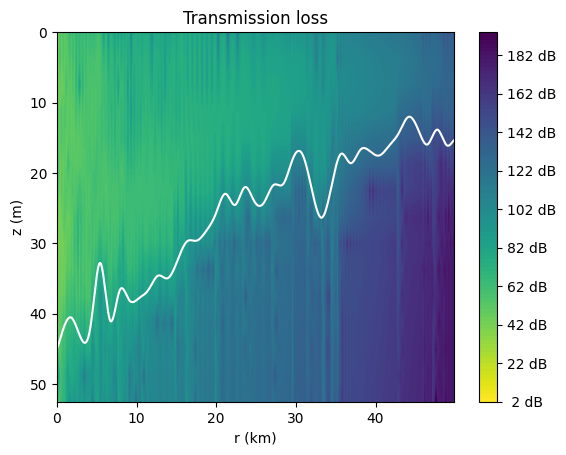

In [72]:
#transmission loss with bathy and ssp superimposed
fig3 = plt.figure(figsize=[8, 10])
fig3 = transm_loss3.plot_vert(angle=0, max_depth=60) #, show_ssp=True)
plt.savefig(f'{storage_cfg()}figures/plot_vert_calmday_line1_03.png', 
                bbox_inches='tight', dpi=200)

<Figure size 800x1000 with 0 Axes>

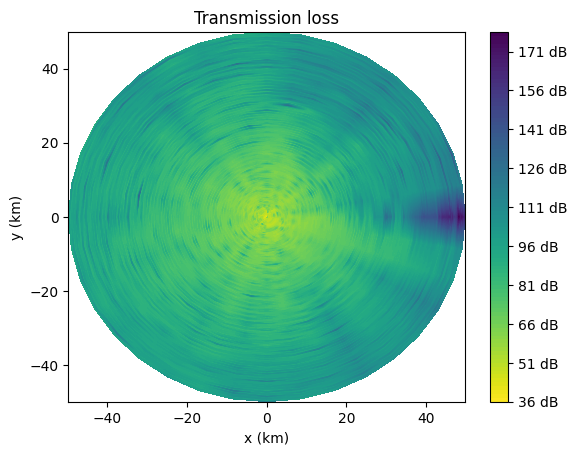

In [73]:
fig4 = plt.figure(figsize=[8, 10])
fig4 = transm_loss3.plot_horiz(rec_depth_idx=1)  # transmission loss at 25 m depth (receiver no. 2)
plt.savefig(f'{storage_cfg()}figures/plot_horizon_calmday_line1_03.png', 
                bbox_inches='tight', dpi=200)

<Figure size 800x1000 with 0 Axes>

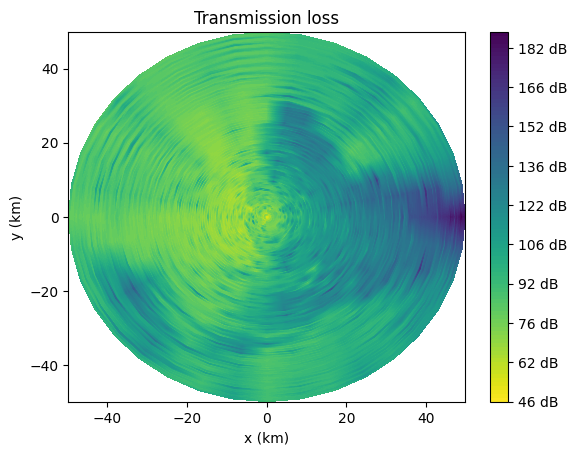

In [74]:
fig5 = plt.figure(figsize=[8, 10])
fig5 = transm_loss3.plot_horiz(rec_depth_idx=2)  # transmission loss at 50 m depth (receiver no. 3)
plt.savefig(f'{storage_cfg()}figures/plot_horizon_calmday_line1_03c.png', 
                bbox_inches='tight', dpi=200)

In [88]:
bounds4 = dict(
               south=44, north=45, west=-61, east=-60,
               start=datetime(2022,8,24), end=datetime(2022,8,25), 
               top=0, bottom=1000
             )

In [89]:
# data sources
data_sources2 = dict(load_bathymetry='gebco', 
                    load_temperature='hycom', 
                    load_salinity='hycom')
                    #load_wind_uv='wwiii', 
                    #load_wind_uv='era5',
                    #load_waveheight='wwiii')
                    #load_waveheight='era5')
# initialize Ocean instance
calm_area2 = kadlu.Ocean(**bounds4, **data_sources2)

Initializing Ocean in region 44.00°N,45.00°N;61.00°W60.00°W,1000m,0m for time period 2022-08-24 00:00:00 to 2022-08-25 00:00:00 with variables: ['bathymetry', 'temperature', 'salinity']
Finished loading bathymetry
  value: shape=(57600,) min=9.000 max=340.000 avg=107.920
    lat: shape=(57600,) min=44.002 max=44.998 avg=44.500
    lon: shape=(57600,) min=-60.998 max=-60.002 avg=-60.500
[HYCOM] Fetching salinity in region 44.00°N,45.00°N;61.00°W60.00°W,1000m,0m for time period 2022-08-24 00:00:00 to 2022-08-25 00:00:00
Finished loading salinity
  value: shape=(55098,) min=30.264 max=34.078 avg=31.493
    lat: shape=(55098,) min=44.000 max=45.000 avg=44.537
    lon: shape=(55098,) min=-60.960 max=-60.000 avg=-60.466
  epoch: shape=(55098,) min=198504.000 max=198528.000 avg=198516.000
  depth: shape=(55098,) min=0.000 max=150.000 avg=32.313
Interpolating 231192 data points on 4D irregular grid using method `nearest` and batch size of 10000
100%|██████████| 24/24 [00:01<00:00, 18.12it/s]
[

In [90]:
seafloor = {'sound_speed':1700,'density':1.5,'attenuation':0.5}
sound_source2 = {'freq': 200, 'lat': 44.33, 'lon': -60.691, 'source_depth': 25}

In [95]:
# initialize transmission loss object
transm_loss4 = transmission_loss(seafloor=seafloor,
                                below_seafloor=False, 
                                propagation_range=50, 
                                **sound_source2,
                                **bounds4, 
                                **data_sources2)

# calculate transmission loss (be patient, this may take a while ...)
_ = transm_loss4.calc(rec_depth=[0.1, 25, 50], vertical=True, nz_max=250)

Initializing Ocean in region 43.79°N,44.87°N;61.45°W59.94°W,1000m,0m for time period 2022-08-24 00:00:00 to 2022-08-25 00:00:00 with variables: ['bathymetry', 'temperature', 'salinity']
Finished loading bathymetry
  value: shape=(93758,) min=-6.000 max=340.000 avg=90.500
    lat: shape=(93758,) min=43.794 max=44.869 avg=44.331
    lon: shape=(93758,) min=-61.444 max=-59.940 avg=-60.692
[HYCOM] Fetching salinity in region 43.79°N,44.87°N;61.45°W59.94°W,1000m,0m for time period 2022-08-24 00:00:00 to 2022-08-25 00:00:00
Finished loading salinity
  value: shape=(79182,) min=30.329 max=34.124 avg=31.505
    lat: shape=(79182,) min=43.800 max=44.840 avg=44.363
    lon: shape=(79182,) min=-61.440 max=-60.000 avg=-60.729
  epoch: shape=(79182,) min=198504.000 max=198528.000 avg=198516.000
  depth: shape=(79182,) min=0.000 max=150.000 avg=29.251
Interpolating 350892 data points on 4D irregular grid using method `nearest` and batch size of 10000
100%|██████████| 36/36 [00:02<00:00, 14.87it/s]
[

<Figure size 800x1000 with 0 Axes>

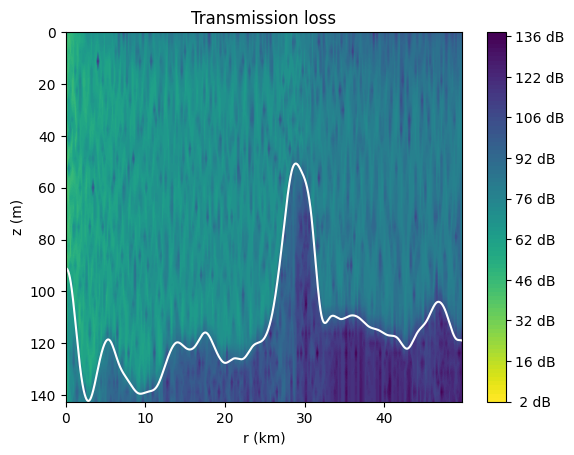

In [96]:
#transmission loss with bathy and ssp superimposed
fig3 = plt.figure(figsize=[8, 10])
fig3 = transm_loss4.plot_vert(angle=0, max_depth=150) #, show_ssp=True)
plt.savefig(f'{storage_cfg()}figures/plot_vert_calmday_line2_02.png', 
                bbox_inches='tight', dpi=200)

<Figure size 800x1000 with 0 Axes>

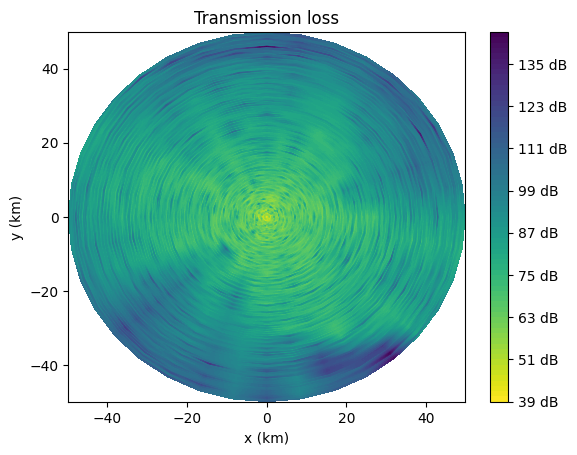

In [97]:
fig4 = plt.figure(figsize=[8, 10])
fig4 = transm_loss4.plot_horiz(rec_depth_idx=1)  # transmission loss at 25 m depth (receiver no. 2)
plt.savefig(f'{storage_cfg()}figures/plot_horizon_calmday_line2_01.png', 
                bbox_inches='tight', dpi=200)

<Figure size 800x1000 with 0 Axes>

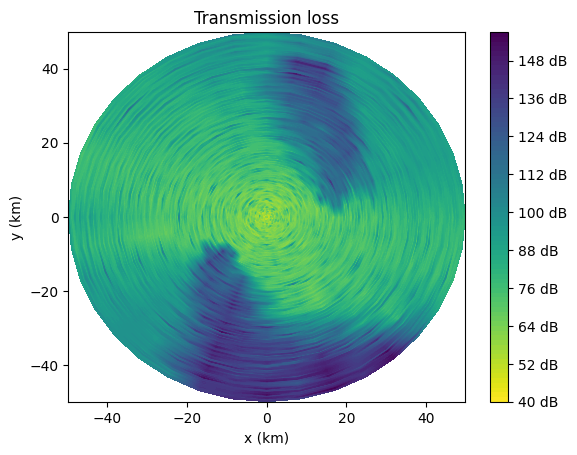

In [98]:
fig5 = plt.figure(figsize=[8, 10])
fig5 = transm_loss4.plot_horiz(rec_depth_idx=2)  # transmission loss at 50 m depth (receiver no. 3)
plt.savefig(f'{storage_cfg()}figures/plot_horizon_calmday_line2_01c.png', 
                bbox_inches='tight', dpi=200)

In [40]:
#bathy2, lat2, lon2 = kadlu.load(
#        var='bathymetry', source='gebco',
#        south=43, west=-63, 
#        north=48, east=-59
#    )
#fig = plt.scatter(lon, lat, c=bathy, cmap=plt.cm.ocean_r)

In [41]:
# ocean boundaries
#bounds2 = dict(
#               south=43, north=48, west=-63, east=-59,
#               start=datetime(2018,12,12), end=datetime(2018,12,13), 
#               top=0, bottom=1000
#             )

In [42]:
# data sources
#data_sources2 = dict(load_bathymetry='gebco')
# initialize Ocean instance
#windarea = kadlu.Ocean(**bounds2, **data_sources2)

In [43]:
#plot2D(var='bathymetry', source='gebco', **bounds2)